In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import chisquare, norm
from statsmodels.stats.multitest import multipletests

In [5]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import chisquare, norm
import scipy.sparse as sp
from statsmodels.stats.multitest import multipletests

In [ ]:
import sys
sys.path.append("..")

from SIGMOD import SIGMOD_SVLR as svlr

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

In [8]:
import scvelo
from sklearn.decomposition import NMF
from sklearn.preprocessing import minmax_scale

In [9]:
sc.set_figure_params(vector_friendly=True, dpi_save=300) 
sns.set_theme(style="white") 
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams.update({
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

In [10]:
adata_vis = sc.read_h5ad("./Data/AD.h5ad")

st_location = pd.read_csv("./Data/visium-v1_coordinates.txt",
                          index_col=0,sep = "\t",header=None,names = ["row","col"])
st_location.index = [i+"-1" for i in st_location.index]
st_location = st_location.loc[adata_vis.obs.index,]

adata_vis.obs[['x','y']] = st_location.loc[:,['row','col']].values

In [12]:
sc.pp.normalize_total(adata_vis, target_sum=1e4)
sc.pp.log1p(adata_vis)

In [13]:
#### 
lr_df = pd.read_csv("/home/liuchang/4.0_Resource/lr/mouse_lr_pair.txt",sep="\t")
lr_df = lr_df[(lr_df['ligand_gene_symbol'].isin(adata_vis.var_names)) & 
              (lr_df['receptor_gene_symbol'].isin(adata_vis.var_names))]

ligand = [ pd.Series(i).values for i in lr_df.ligand_gene_symbol.values]
receptor = [ pd.Series(i).values for i in lr_df.receptor_gene_symbol.values]

In [14]:
layer = adata_vis.obs
KNN_df=svlr.get_KNN_graph(layer,2,)

Spatial Variable Ligand Receptor Interaction Identification

In [15]:
cells = np.array(adata_vis.obs_names)
cells_id_tran = dict(zip(cells, range(cells.shape[0])))
KNN_df['Cell1_ID'] = KNN_df['Cell1'].map(cells_id_tran)
KNN_df['Cell2_ID'] = KNN_df['Cell2'].map(cells_id_tran)

In [16]:
layer["cell_order"] =  layer.index.map(cells_id_tran)

In [17]:
n = 3 
mx = 5
my = 5

x_range = [layer['x'].min(), layer['x'].max()]
y_range = [layer['y'].min(), layer['y'].max()]
x_step = (x_range[1] - x_range[0] - mx * (n - 1)) / n
y_step = (y_range[1] - y_range[0] - my * (n - 1)) / n

subspaces = svlr.create_subspaces(layer, n, x_range, y_range, x_step, y_step, mx, my)
selected_subspaces = {key: val for key, val in subspaces.items() if len(val) > 10}

In [19]:
G_df = KNN_df.copy()
dist_mat = sp.coo_matrix((G_df['Distance'], (G_df['Cell1_ID'], G_df['Cell2_ID'])), shape=(adata_vis.n_obs, 
                                                                                          adata_vis.n_obs))
dist_mat = dist_mat + sp.eye(dist_mat.shape[0])
dist_mat = dist_mat.toarray()

In [20]:
lr_res,lr_pair,ligands,receptors = svlr.run_svlr(ligand,
                               receptor,
                               dist_mat,
                               selected_subspaces,
                               adata_vis)

mean spots in each subspaces is:  393


  0%|          | 0/2030 [00:00<?, ?it/s]

In [21]:
# Convert results to DataFrame
lr_res_df = pd.DataFrame(lr_res, columns=list(selected_subspaces.keys())+['density_p', 'L_R_mean_strength', 'L_R_mean_z'])
lr_res_df.index = lr_pair
lr_res_df['ligands'] = ligands
lr_res_df['receptors'] = receptors
lr_res_df.index = lr_pair
lr_res_df = lr_res_df.fillna(1)
lr_res_df['mean_p'] = lr_res_df['L_R_mean_z'].apply(lambda z: 1 - norm.cdf(z) if z > 0 else norm.cdf(z)) # 基于标准正态分布计算互作强度的p值
# Apply Bonferroni correction for multiple testing on p-values and chi.p-values
lr_res_df['mean_fdr'] = multipletests(lr_res_df['mean_p'], method='bonferroni')[1]
lr_res_df['density_fdr'] = multipletests(lr_res_df['density_p'], method='bonferroni')[1]
lr_res_df['mean_fdr_log'] = -np.log10(lr_res_df['mean_fdr'])
lr_res_df['density_fdr_log'] = -np.log10(lr_res_df['density_fdr'])
lr_res_df['density_p_log'] = -np.log10(lr_res_df['density_p'])

In [22]:
lr_res_df.to_csv("Results/lr_res.csv",index=True,header=True)

In [31]:
lr_res_df_0_05 = lr_res_df[(lr_res_df['mean_fdr'] < 0.05) & (lr_res_df['L_R_mean_z'] > 0) & (lr_res_df['density_fdr'] < 0.05)]
lr_res_df_0_05["annotation"] = "Secreted Signaling"

In [32]:
lr_res_df_0_05

Subspace_1_1  Subspace_1_2  Subspace_1_3  Subspace_2_1  \
Wnt3_Fzd6          2.743536      1.713863      0.871805      1.975188   
Wnt3_Fzd1          1.959669      0.395507      0.737681      1.357942   
Wnt3_Fzd8          1.371768      0.725096      0.268248      0.864145   
Efnb2_Ephb6       85.441563     52.997932     44.327924     64.687403   
Efnb2_Ephb1       47.326003     31.179132     26.489455     76.229907   
...                     ...           ...           ...           ...   
Ngf_Sort1         18.518871     16.215785     13.948878      6.913158   
Nxph1_Nrxn2      107.683805     51.547740     57.270873     38.639613   
Slit2_Robo3       44.484484     21.159622     12.004082      1.913463   
Sema6b_Plxna4    108.075739     67.631689     56.197882     43.701032   
Slit2_Robo2       74.565401     40.078038     23.136360     20.616024   

               Subspace_2_2  Subspace_2_3  Subspace_3_1  Subspace_3_2  \
Wnt3_Fzd6         25.807367      8.274149      1.159689      2.765615   
Wnt3_Fzd1         12.800039     13.909131      1.014728      1.985570   
Wnt3_Fzd8         13.525548      9.415411      1.304651      1.560091   
Efnb2_Ephb6        6.063176     15.549695     52.403463     13.686250   
Efnb2_Ephb1        8.965210     10.984647     53.708113     13.189857   
...                     ...           ...           ...           ...   
Ngf_Sort1         41.405795     18.688165      6.450772      8.013193   
Nxph1_Nrxn2       49.127276     67.049142     67.696866     67.225725   
Slit2_Robo3        1.243729      4.565048      2.826743      3.332921   
Sema6b_Plxna4     54.724055     59.916255     76.249575     54.674086   
Slit2_Robo2        6.322287     13.980459     27.687583     24.606885   

               Subspace_3_3     density_p  ...  L_R_mean_z  ligands receptors  \
Wnt3_Fzd6          0.944745  2.088704e-18  ...   20.503124     Wnt3      Fzd6   
Wnt3_Fzd1          1.259660  8.539179e-10  ...   11.507614     Wnt3      Fzd1   
Wnt3_Fzd8          0.314915  2.555750e-09  ...   13.779965     Wnt3      Fzd8   
Efnb2_Ephb6        3.464066  1.522947e-34  ...    7.776116    Efnb2     Ephb6   
Efnb2_Ephb1        7.243047  1.304369e-28  ...    6.293007    Efnb2     Ephb1   
...                     ...           ...  ...         ...      ...       ...   
Ngf_Sort1         11.022029  7.483520e-10  ...    4.255805      Ngf     Sort1   
Nxph1_Nrxn2       39.364388  1.196659e-09  ...    6.407282    Nxph1     Nrxn2   
Slit2_Robo3        1.574576  1.602005e-30  ...    4.753795    Slit2     Robo3   
Sema6b_Plxna4     23.618633  3.271709e-12  ...    4.974930   Sema6b    Plxna4   
Slit2_Robo2        6.613217  7.587534e-25  ...    5.249814    Slit2     Robo2   

                     mean_p      mean_fdr   density_fdr  mean_fdr_log  \
Wnt3_Fzd6      0.000000e+00  0.000000e+00  4.240070e-15           inf   
Wnt3_Fzd1      0.000000e+00  0.000000e+00  1.733453e-06           inf   
Wnt3_Fzd8      0.000000e+00  0.000000e+00  5.188173e-06           inf   
Efnb2_Ephb6    3.774758e-15  7.662759e-12  3.091583e-31     11.115615   
Efnb2_Ephb1    1.556872e-10  3.160451e-07  2.647869e-25      6.500251   
...                     ...           ...           ...           ...   
Ngf_Sort1      1.041492e-05  2.114228e-02  1.519154e-06      1.674848   
Nxph1_Nrxn2    7.406842e-11  1.503589e-07  2.429218e-06      6.822871   
Slit2_Robo3    9.981652e-07  2.026275e-03  3.252071e-27      2.693302   
Sema6b_Plxna4  3.263563e-07  6.625032e-04  6.641569e-09      3.178812   
Slit2_Robo2    7.612646e-08  1.545367e-04  1.540269e-21      3.810968   

               density_fdr_log  density_p_log          annotation  
Wnt3_Fzd6            14.372627      17.680123  Secreted Signaling  
Wnt3_Fzd1             5.761088       9.068584  Secreted Signaling  
Wnt3_Fzd8             5.284986       8.592482  Secreted Signaling  
Efnb2_Ephb6          30.509819      33.817315  Secreted Signaling  
Efnb2_Ephb1          24.577104      27.884600  Secreted Signaling  
...

In [34]:
# lr_res_df_0_05.replace([np.inf, -np.inf], 60, inplace=True)
lr_res_df['mean_fdr_log'] = -np.log10(lr_res_df['mean_fdr']+1e-20)
lr_res_df['density_fdr_log'] = -np.log10(lr_res_df['density_fdr']+1e-20)

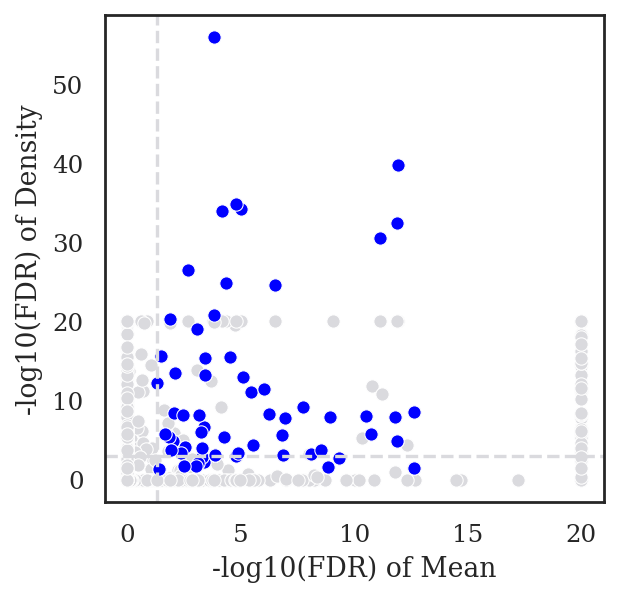

In [36]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)

sns.scatterplot(data=lr_res_df, x="mean_fdr_log", y="density_fdr_log", color="#DADADE", ax=ax)

sns.scatterplot(data=lr_res_df_0_05, x="mean_fdr_log", y="density_fdr_log", color="blue", ax=ax)

plt.axhline(y=-np.log10(1e-3), ls='--', color='#DADADE') 
plt.axvline(x=-np.log10(0.05), ls='--', color='#DADADE') 

# annotations = [
#     ax.annotate(
#         lr_res_df_0_05.index[i],
#         (lr_res_df_0_05.mean_fdr_log[i], lr_res_df_0_05.density_p_log[i]),
#         fontsize=8 
#     )
#     for i in range(lr_res_df_0_05.shape[0])
# ]

# adjust_text(annotations, arrowprops=dict(arrowstyle='-', color='grey'))

plt.xlabel("-log10(FDR) of Mean", fontsize=12)
plt.ylabel("-log10(FDR) of Density", fontsize=12)

plt.savefig("./Figure/1_LR_density_vs_mean.pdf", format="pdf", bbox_inches="tight", dpi=1000)
plt.show()

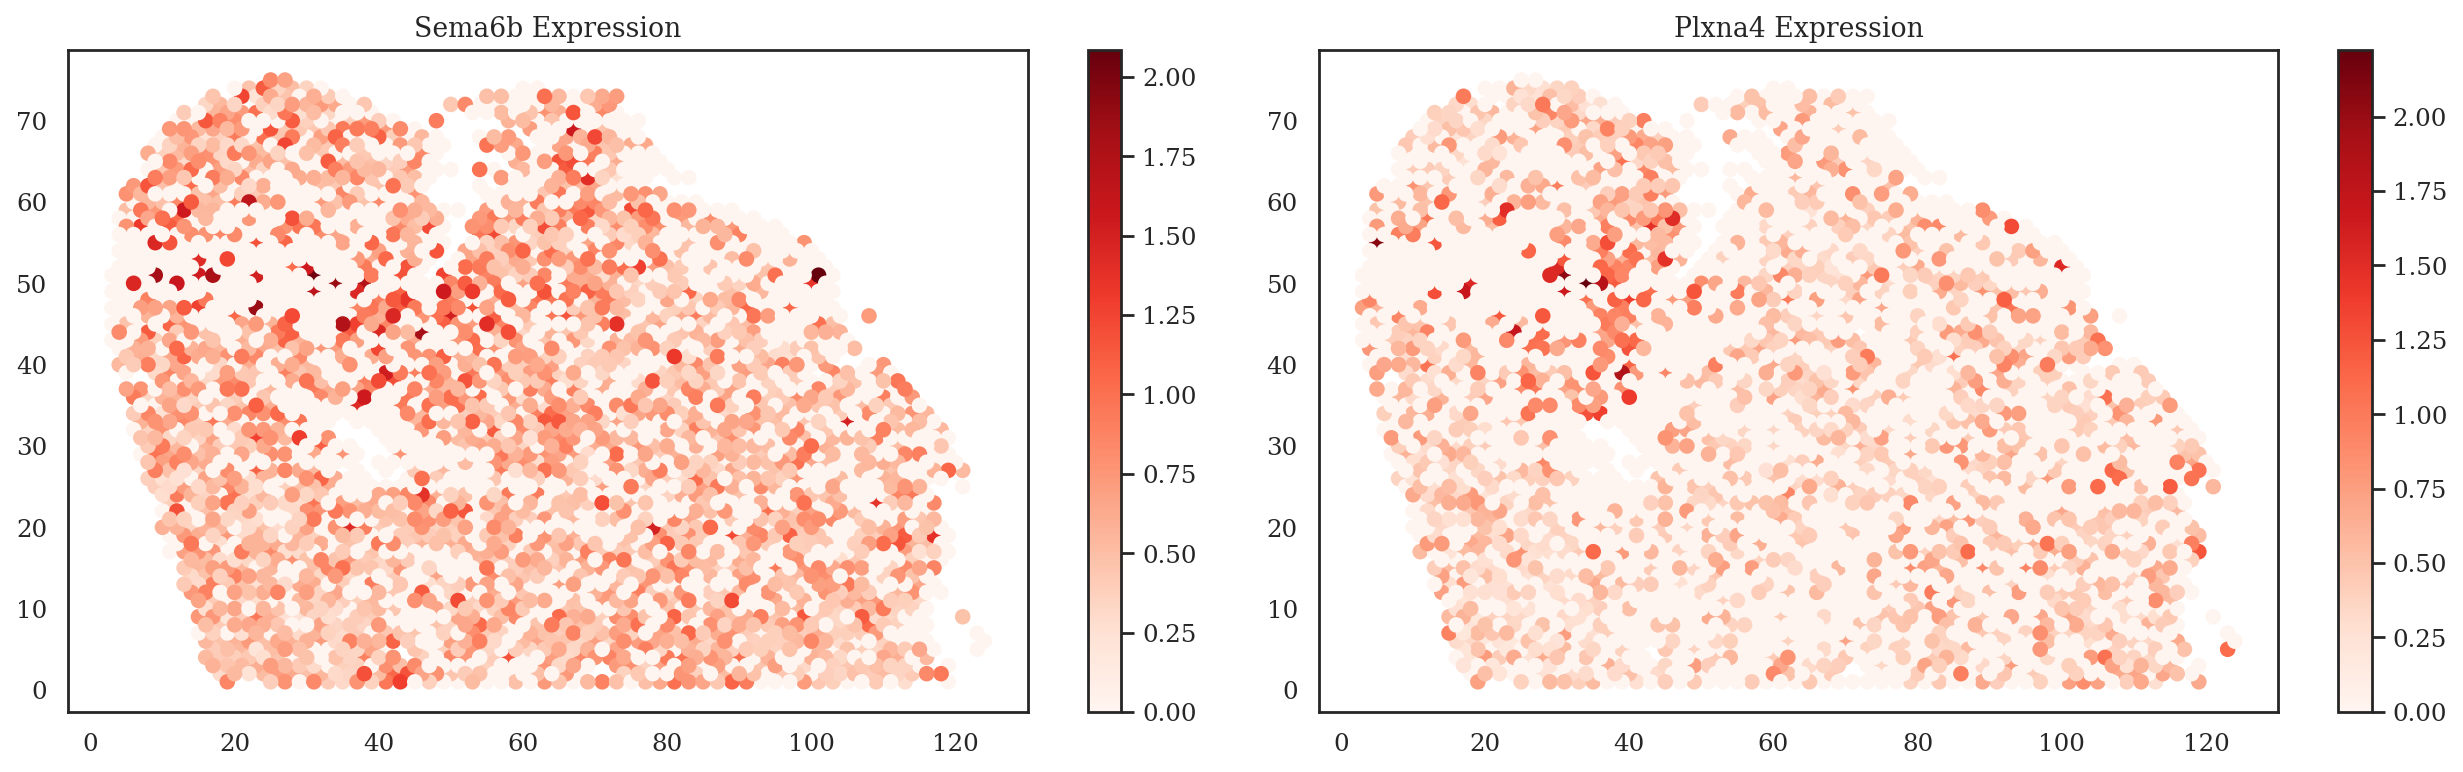

In [41]:
svlr.plotLR("Sema6b_Plxna4",adata_vis,layer.loc[:,['x','y']])

## Annotate region based on L-R interactions

In [42]:
lr_res = lr_res_df_0_05
pos = adata_vis.obs.loc[:,["x","y"]]
l_secrete = 6/2
l_contact = 2/3

niche_res,secrete_index,contact_index = svlr.Create_Niche(adata_vis,
                                                          pos,
                                                          l_secrete,
                                                          l_contact,
                                                          lr_res)

  0%|          | 0/105 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [43]:
niche_res_df = pd.concat(niche_res,axis=1)
niche_res_df.columns = secrete_index.append(contact_index)

# Convert Ligand Receptor to Niche
## Preprocess min-max normalization alongside lr axis

In [44]:
niche_res_numpy = niche_res_df.to_numpy()
niche_res_numpy_minmax = minmax_scale(niche_res_numpy, feature_range=(0,1), axis=0)

In [45]:
%%time
model = NMF(n_components=12, init='random', random_state=0)
A_ = model.fit_transform(niche_res_numpy_minmax)
B_ = model.components_

CPU times: user 2.42 s, sys: 16.6 s, total: 19 s
Wall time: 927 ms


In [46]:
A_df = pd.DataFrame(A_)
A_df.to_csv("Results/niche_res_topic12_0512.csv",index=False)
B_df = pd.DataFrame(B_,index=["Niche"+str(i+1) for i in range(12)],columns = lr_res.index)
B_df.to_csv("Results/LR_niche_topic12_0512.csv",index=True)

In [11]:
adata_vis.obs["y_1"] = adata_vis.obs["y"].to_numpy() * (-1)
adata_vis.obsm["spatial"] = adata_vis.obs[["x", "y_1"]].copy().to_numpy()

In [17]:
for i in range(12):
    adata_vis.obs.loc[:,'Niche'+str(i+1)] = A_df.values[:,i]

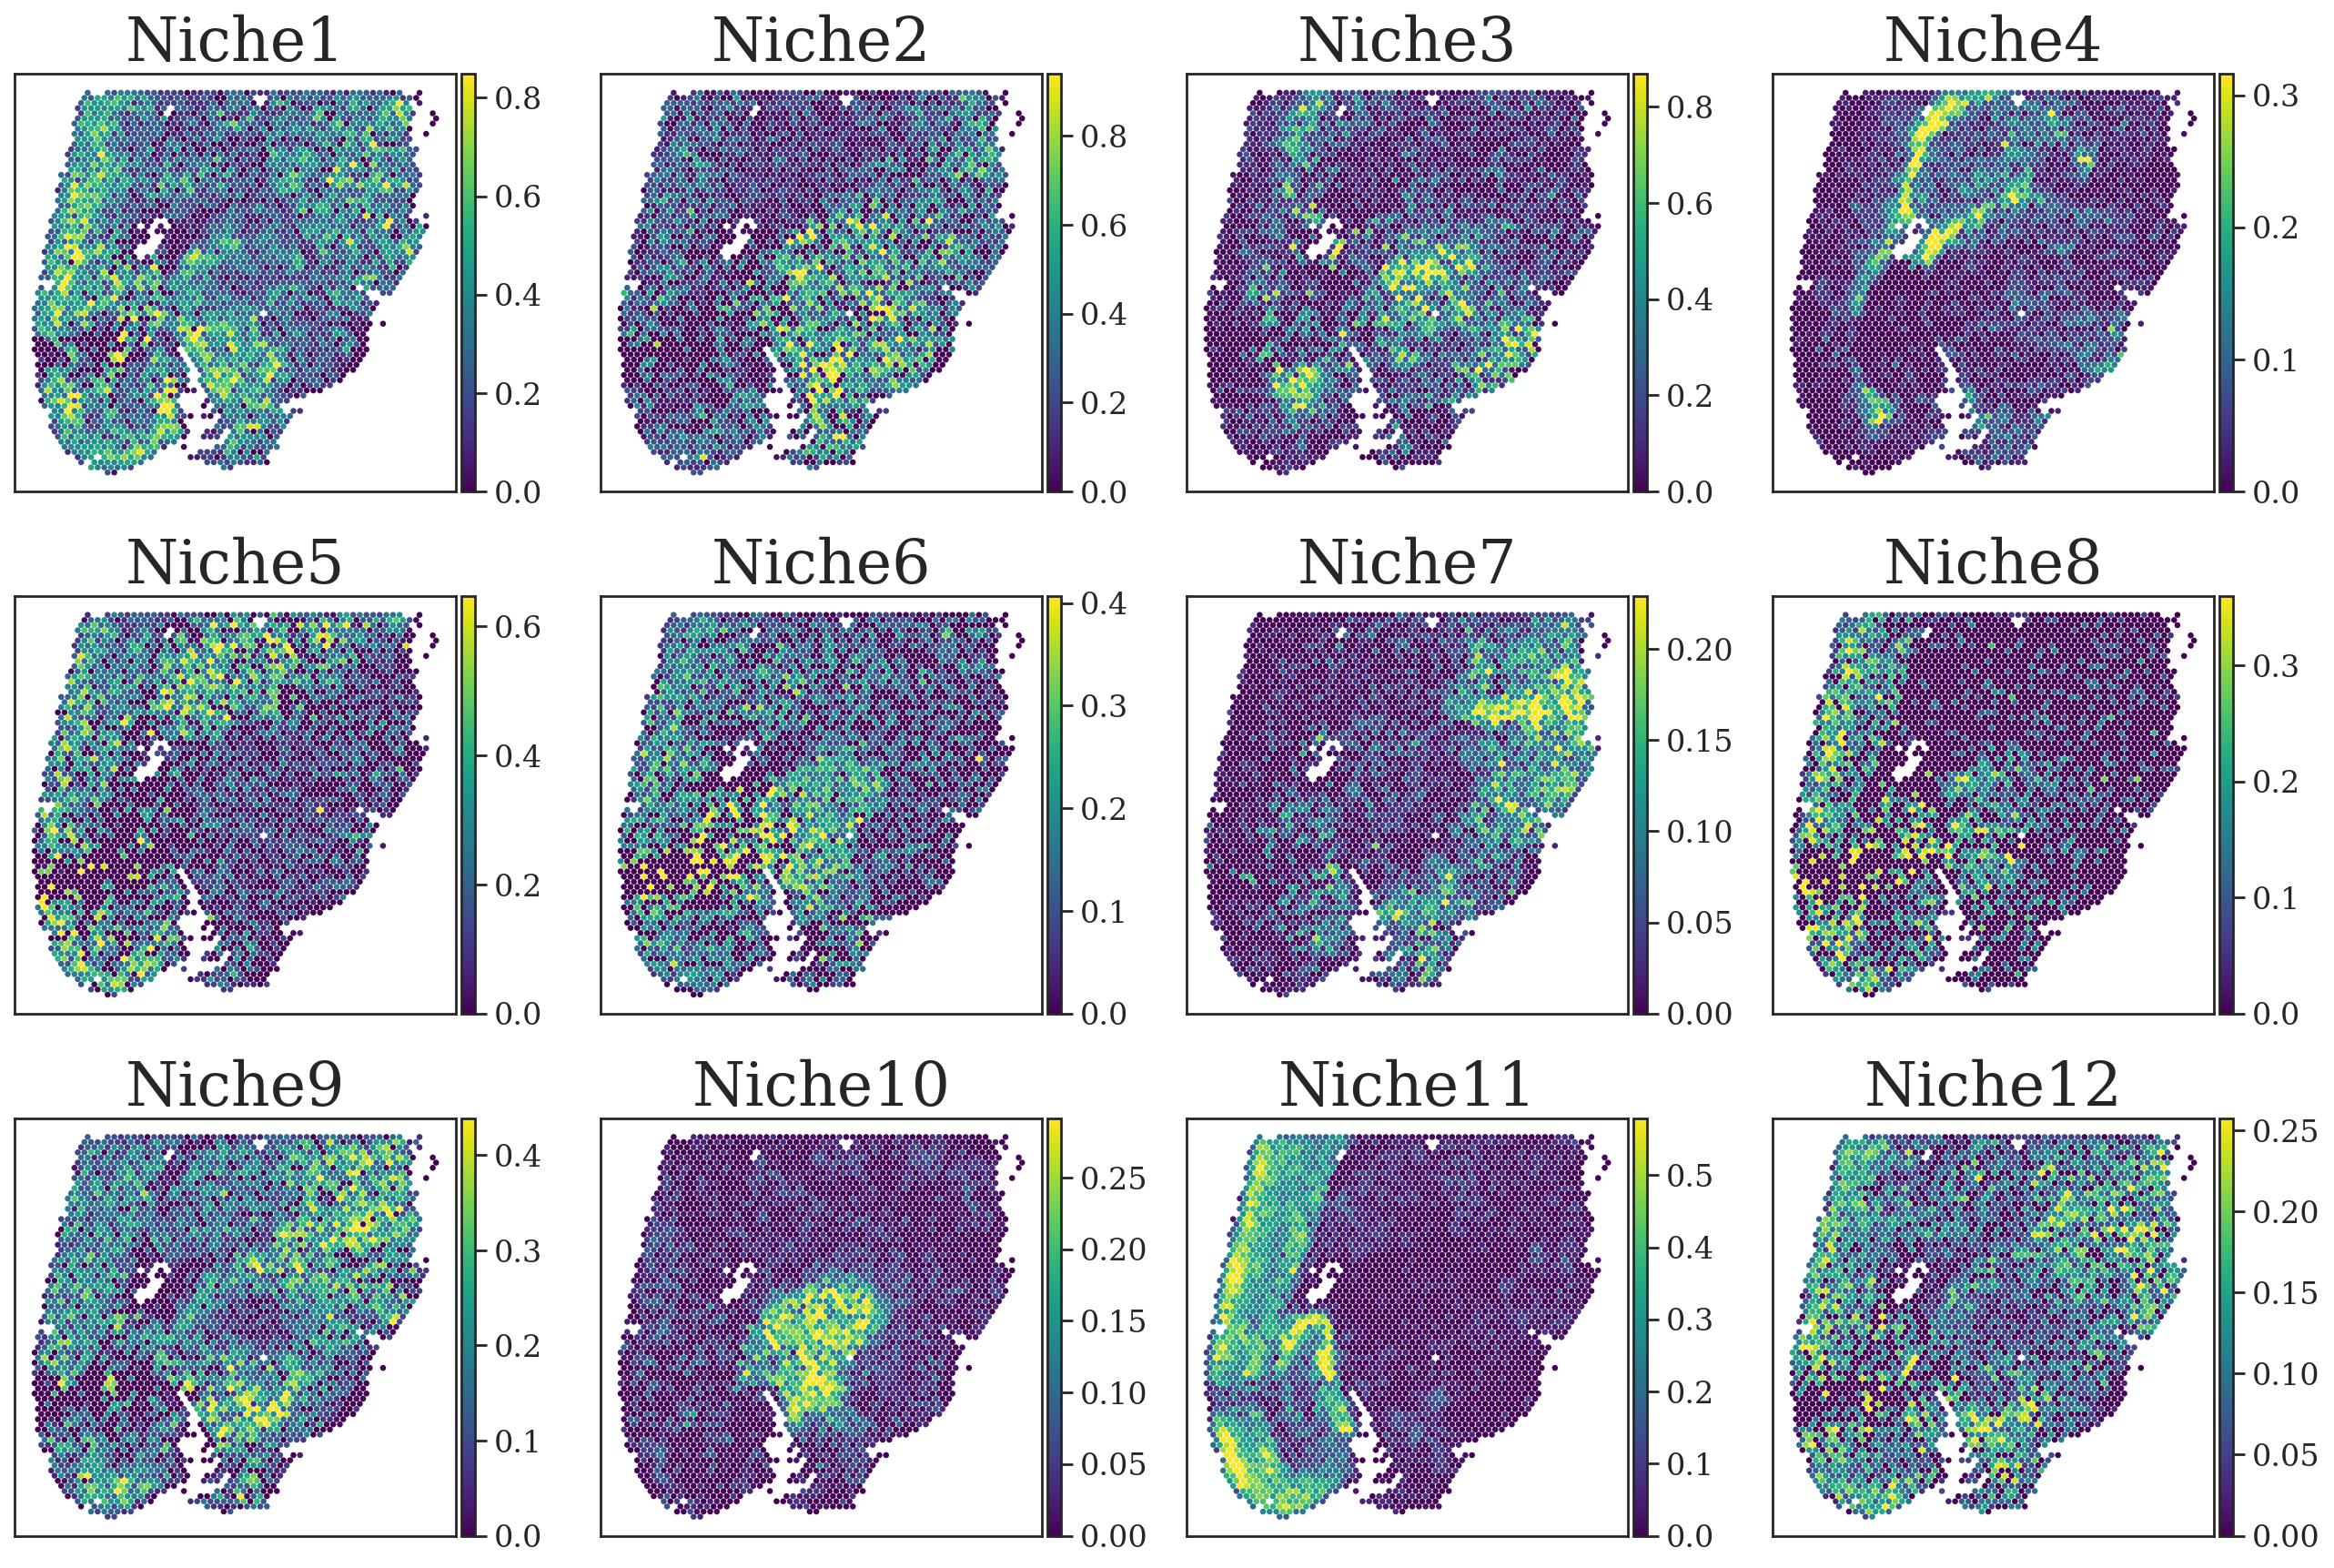

In [18]:
cellsForplot = ['Niche'+str(i+1) for i in range(12)]

ax = sc.pl.embedding(
    adata_vis,
    basis="spatial",
    show=False,
    color=cellsForplot,
    cmap="viridis",
    vmax='p99',
    #size=12,
    ncols=4,
)

# Manually set rasterization for collections
for a in plt.gcf().axes:  # Traverse each axis
    if hasattr(a, 'collections'):
        for collection in a.collections:
            collection.set_rasterized(True)  # Rasterize the points to reduce file size

# # Adjust colorbar font size
for ax in plt.gcf().axes:
    if isinstance(ax, plt.Axes):
        if hasattr(ax, 'collections') and ax.collections:
            for collection in ax.collections:
                if hasattr(collection, 'colorbar') and collection.colorbar:
                    cbar = collection.colorbar
                    cbar.ax.tick_params(labelsize=15)  # Set colorbar tick font size
    ax.set_xlabel('')  # Clear x-axis label
    ax.set_ylabel('')  # Clear y-axis label

cellsForplot_with_spaces = []
for element in cellsForplot:
    cellsForplot_with_spaces.append(element)
    cellsForplot_with_spaces.append("")

for ax, title in zip(plt.gcf().axes, cellsForplot_with_spaces):
    if isinstance(ax, plt.Axes):
        ax.set_title(title, fontsize=30)

# ax.invert_yaxis()
# ax.set_aspect("equal")

plt.tight_layout()  # Adjust layout to fit titles properly 
# remove bbox_inches='tight' for color legend show
plt.savefig('Figure/2_SpatialPlot_Niche.pdf', dpi=300)
plt.show()

In [24]:
B_df = B_df.T

In [25]:
from matplotlib.colors import LinearSegmentedColormap

In [26]:
sc.set_figure_params(vector_friendly=True, dpi_save=300) 
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams.update({
    'pdf.fonttype': 42, 
    'ps.fonttype': 42 
})

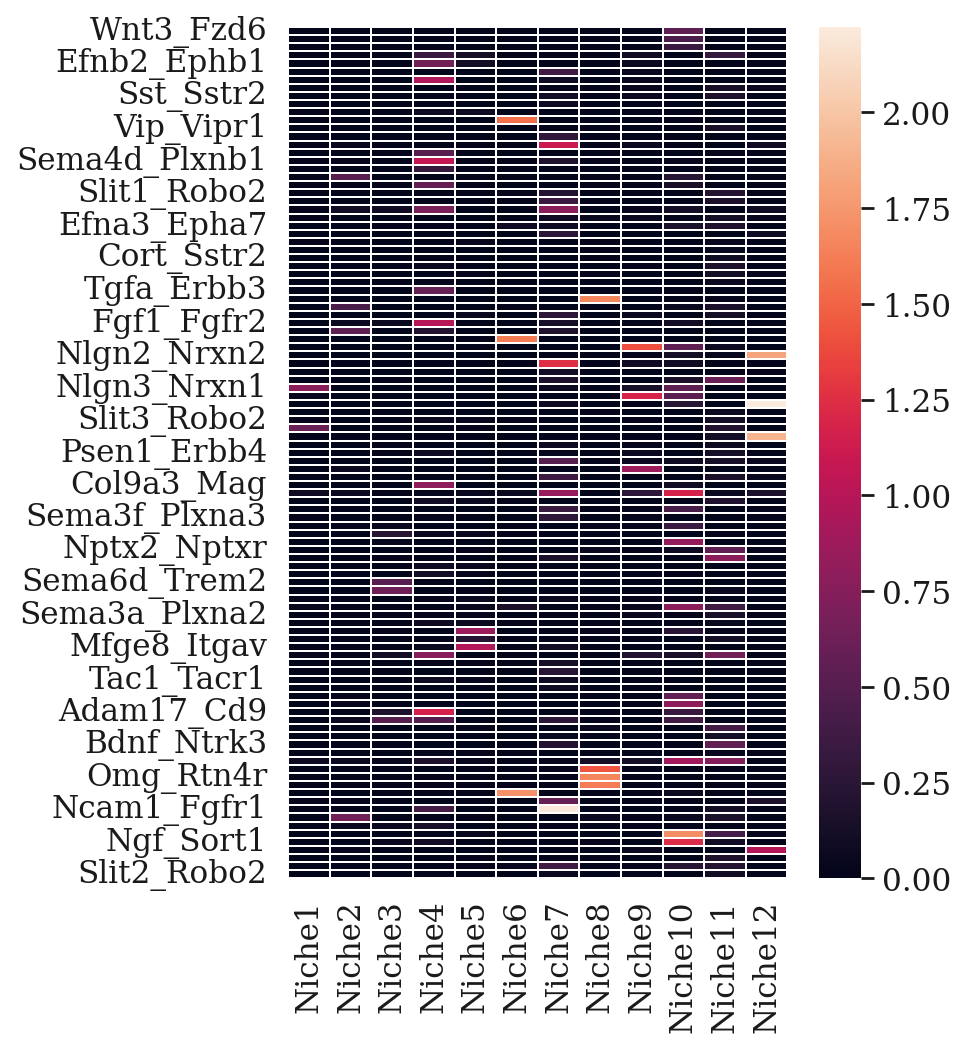

In [29]:
plt.figure(figsize=(5, 7))
sns.heatmap(B_df,linewidths=0.1, linecolor='white')
plt.savefig("./Figure/2_2_LR_2_Niche.pdf", format="pdf", bbox_inches="tight", dpi=1000)
plt.show()